In [194]:
%reset -sf

In [195]:
#!/usr/bin/env python3
import sys
import math, random
import functools, itertools, collections, heapq, bisect
from collections import Counter, defaultdict, deque

# available on Google, AtCoder Python3, not available on Codeforces
# import numpy as np
# import scipy

M9 = 10**9 + 7  # 998244353
yes, no = "YES", "NO"
# d4 = [(1,0),(0,1),(-1,0),(0,-1)]
# d8 = [(1,0),(1,1),(0,1),(-1,1),(-1,0),(-1,-1),(0,-1),(1,-1)]
# d6 = [(2,0),(1,1),(-1,1),(-2,0),(-1,-1),(1,-1)]  # hexagonal layout
MAXINT = sys.maxsize

In [196]:
srr = """
6,10
0,14
9,10
0,3
10,4
4,11
6,0
6,12
4,1
0,13
10,12
3,4
3,0
8,4
1,10
2,14
8,10
9,0

fold along y=7
fold along x=5
""".strip()

# srr = """
# """.strip()

with open("/Users/hkmac/Downloads/input.txt") as f:
    srr = f.read().strip()
    
inp1, inp2 = srr.split("\n\n")
inp1 = inp1.strip().split("\n")
inp2 = inp2.strip().split("\n")

inp1 = [[int(x) for x in row.split(",")] for row in inp1]


In [132]:
fold along x=655

SyntaxError: invalid syntax (<ipython-input-132-b89a34eb065b>, line 1)

In [133]:
y=7
x=5

SyntaxError: invalid syntax (<ipython-input-134-a871c944c40b>, line 1)

In [197]:
arr = [(abs(x),abs(y-7)) for x,y in arr]

arr = [(abs(x-5),abs(y)) for x,y in arr]

NameError: name 'arr' is not defined

In [198]:
arr

NameError: name 'arr' is not defined

In [ ]:
fold along x=655

fold along y=447

fold along x=327

fold along y=223

fold along x=163

fold along y=111

fold along x=81

fold along y=55

fold along x=40

fold along y=27
fold along y=13
fold along y=6

In [240]:
arr = [x for x in inp1]

In [241]:
arr = [(abs(x-655),abs(y)) for x,y in arr]

arr = [(abs(x),abs(y-447)) for x,y in arr]

arr = [(abs(x-327),abs(y)) for x,y in arr]

arr = [(abs(x),abs(y-223)) for x,y in arr]

arr = [(abs(x-163),abs(y)) for x,y in arr]

arr = [(abs(x),abs(y-111)) for x,y in arr]

arr = [(abs(x-81),abs(y)) for x,y in arr]

arr = [(abs(x),abs(y-55)) for x,y in arr]

arr = [(abs(x-40),abs(y)) for x,y in arr]

arr = [(abs(x),abs(y-27)) for x,y in arr]

arr = [(abs(x),abs(y-13)) for x,y in arr]

arr = [(abs(x),abs(y-6)) for x,y in arr]    

In [242]:
print(len(set(arr)))

282


In [243]:
import matplotlib.pyplot as plt

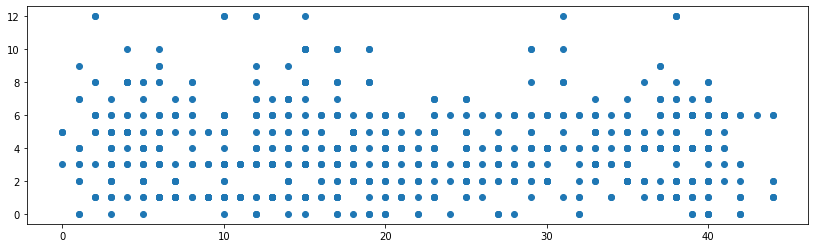

In [244]:
plt.figure(figsize=(14,4))
plt.scatter([x for x,y in arr], [y for x,y in arr])
